# Notebook for CAV2020 Artifact Evaluation - Submission 233

This notebook contains the tests to reproduce the results presented in our paper titled *Qualitative Controller Synthesis for Consumption Markov Decision Processes*. It also helps understand the package structure for ease of reusability.

Please note that the computation time for different tasks reported in the paper change based on the machine configuration but the scalabilty remains the same. The following computation times are obtained using a machine with the Intel® Core™ i7-8700 CPU @ 3.20GHz × 12 processor and a RAM of 16 GB running Ubuntu 18.04 LTS. This is a different configuration than the desktop used to generate the results reported in the paper and hence the computation times can be a little different. 

We provide detailed documentation and installation instructions using the documentation served using Sphinx and ReadtheDocs at the following links: [online version](https://fimdp.readthedocs.io/en/latest/) and [offline version - works in docker only](http://localhost:7777/view/docs/build/html/index.html).

While all the tests below are self-contained, we encourage you to have a look at other example notebooks. You can find brief descriptions of other example notebooks in the readme file in the current directory or at this [ReadtheDocs link](https://fimdp.readthedocs.io/en/latest/examples.html).

We consider the following two case-studies in our paper which model the problems of an electric vehicle routing with limited capacity and a multi-agent grid world inspired by the Mars 2020 mission. For detailed description of the problems, refer to the **Implementation and Case Studies** section of the paper or the following links:

* Description of Electric Vehicle Routing Problem: [ReadtheDocs link](https://fimdp.readthedocs.io/en/latest/examples.html#electric-vehicle-routing) or 
[Offline link - works in docker only](http://localhost:7777/view/docs/build/html/examples.html#electric-vehicle-routing)
* Description of Multi-agent Grid World Problem: [ReadtheDocs link](https://fimdp.readthedocs.io/en/latest/examples.html#multi-agent-grid-world) or 
[Offline link - works in docker only](http://localhost:7777/view/docs/build/html/examples.html#multi-agent-grid-world)


The following two subsections reproduce the results from the corresponding subsections in the **Implementation and Case Studies** section of the paper.

## Electric Vehicle Routing

This subsection reproduces the results in section *7.1 Electric Vehicle Routing* of the paper. We begin with importing required modules from fimdp.

In [46]:
import fimdpenv.nyc_parser as nyc_parser
import fimdpenv.NYCtools as NYCtools
from fimdp.energy_solver import *
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
from fimdp.consMDP import ConsMDP
from fimdp.products import product_energy
from mec_decomposition import get_MECs

We generate the consMDP object representing the consumption MDP modeling the problem of electric vehicle routing in NYC. NYCstreetnetwork.json contains a stochastic energy consumption model covering all the streets in central Manhattan, New York City.

In [4]:
m, targets = nyc_parser.parse('NYCstreetnetwork.json')

### Mean computation time for different objectives

Mean computation time for *Safe* objective (safety) for an energy capacity of 100.

In [3]:
%%timeit
m.get_safe(100, recompute=True)

1.07 s ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Mean computation time for *SafePR_T* (postive reachability) objective for an energy capacity of 100.

In [14]:
%%timeit
m.get_positiveReachability(targets, 100, recompute=True)

1.39 s ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Mean computation time for *SafeBüchi_T* (Büchi) objective for an energy capacity of 100.

In [16]:
%%timeit
m.get_Buchi(targets, 100, recompute=True)

1.42 s ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Mean computation time for different capacities

We now analyze the variation of computation time for different capacities. The task is to generate a strategy with Buchi objective, same as the above experiments. We consider a maximum value of capacity 200 and split the interval [0, 200] into 20 intervals and use the interval bounds as the different values of capacities we calculate computation time for. Further, for each capacity value, we repeat the test multiple times to account for variations in the computation time. These results were reported in Fig. 4(a) of the paper.

,capacity,time(sec)
0,1,0.153674
1,11,1.069634
2,21,2.052743
3,32,3.304975
4,42,4.211226
5,53,3.238880
6,63,3.012353
7,74,2.284341
8,84,1.845679
9,95,1.756329


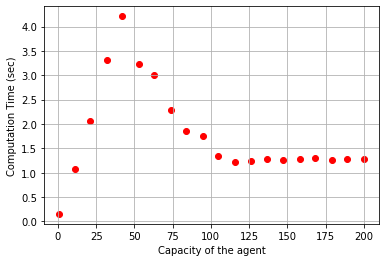

In [77]:
comptime = NYCtools.timeit_diffcaps(m, targets, cap_bound = 200, num_samples = 20, num_tests=5, obj=BUCHI)
x_val = [pair[0] for pair in comptime]; y_val = [pair[1] for pair in comptime]
plt.scatter(x_val, y_val, color='red')
plt.xlabel('Capacity of the agent'); plt.ylabel('Computation Time (sec)'); plt.grid()
df_caps = pd.DataFrame(comptime, columns=['capacity','time(sec)'])
df_caps.to_csv("comptime_diffcaps.csv")
df_caps

We now compare our results with an approach that encodes the information about energy levels directly in the state-space. We compute the running time for MEC-decomposition (part of almost-sure Büchi algo) of the explicit representation of the MDP. Please note that the running times for computing the set of explicit-states would be still larger than just the time needed for the MEC-decomposition. The following script can be used to reproduce the results reported in Fig. 4(b) of the paper.

In [65]:
def explicit_mecs(consMDP, T, caps_list, num_tests):
    comptime = []
    for cap in caps_list:
        p, TT = product_energy(consMDP, cap, T)
        def calc_time():
            mecs = get_MECs(p)
        comptime.append((cap, p.num_states, timeit.timeit(calc_time, number=num_tests)/num_tests))
    return comptime

,capacity,no.of explicit states,time(sec)
0,1,7700,0.038060
1,11,29818,0.222584
2,21,75622,0.765968
3,32,139342,2.417092
4,42,200199,6.651672
5,53,268055,14.960706
6,63,329833,30.682056
7,74,397835,61.671274
8,84,459592,119.885437
9,95,527475,236.988935


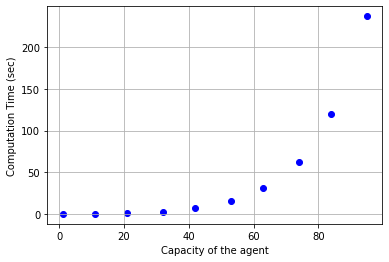

In [76]:
caps_list = [1,11,21,32,42,53,63,74,84,95]
comptime_explicit = explicit_mecs(m, targets, caps_list, 3)
x_val = [val[0] for val in comptime_explicit]; y_val = [val[2] for val in comptime_explicit]
plt.scatter(x_val, y_val, color='blue')
plt.xlabel('Capacity of the agent'); plt.ylabel('Computation Time (sec)'); plt.grid()
df_explicit = pd.DataFrame(comptime_explicit, columns=['capacity', 'no.of explicit states','time(sec)'])
df_explicit.to_csv("comptime_explicit.csv")
df_explicit

### Mean computation Time of Different Sizes of Target Set

Now, we analyize how the computation time changes with the size of the targets. We randomly generate target sets of different sizes and calculate the computation time for the same capacity for Buchi objective. We use a capacity of 50 and generate target sets of varying sizes in the interval [20, size_bound] and use them to evaluate the strategy and calculate the computation time. For each target set, we repeat the tests multiple times to account for variations in the computation time.

,target set size,time(sec)
0,20,4.987085
1,29,5.886724
2,38,5.917273
3,48,7.077351
4,57,7.357079
5,67,4.942268
6,76,6.238028
7,86,3.991735
8,95,4.095056
9,105,4.265142


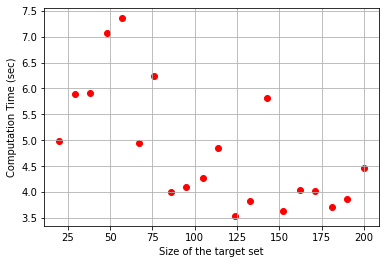

In [13]:
comptime = NYCtools.timeit_difftargetsizes(m, cap=50, size_bound = 200, num_samples = 20, num_tests=2, obj=BUCHI)
x_val = [pair[0] for pair in comptime]; y_val = [pair[1] for pair in comptime]
plt.scatter(x_val, y_val, color='red')
plt.xlabel('Size of the target set'); plt.ylabel('Computation Time (sec)'); plt.grid()
df_ts = pd.DataFrame(comptime, columns=['target set size','time(sec)'])
df_ts.to_csv("comptime_difftargetsizes.csv")
df_ts

### Mean computation time for Different Target Sets

We now analyze how the computation time varies for different target sets. The function 'timeit_difftargets()' calculates the computation time of computing the strategy with Buchi objective for 'num_samples' different randomly generated target sets. The resulting compute time is plotted as a histogram as shown below. We consider a capacity of 100 and target set size of 50 for this analysis.

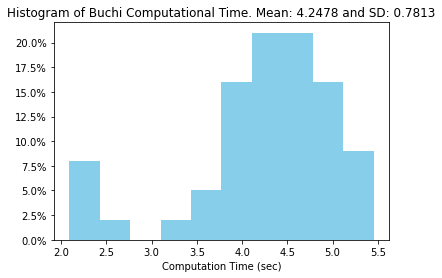

In [14]:
comptime = NYCtools.timeit_difftargets(m, cap=100, target_size = 50, num_samples=100, obj=BUCHI)
NYCtools.histogram(comptime)

## Multi-agent Grid World

This subsection reproduces the results in section *7.2 Multi-agent Grid World* of the paper. We begin with importing required modules from fimdp. **Note that an environment with a grid size $n$ has $n^4$ states in the corresponding Consumption MDP.**

In [7]:
import sys; sys.path.insert(0, '..')
from fimdp.MarsEnv import MarsEnv
from fimdp.energy_solver import *

### Mean computation time for different objectives

We begin by creating a environment with grid size $n = 10$ and agent capacity of 10 units.

In [104]:
env = MarsEnv(grid_size=10, agent_capacity=10, agent_actioncost=1, agent_staycost=1)
m, targets = env.get_mdp_targets()

Mean computation time for *Safe* objective (safety) for an energy capacity of 10.

In [105]:
%%timeit
s = BasicES(m, cap=env.agent_capacity, targets=targets)
strategy = s.get_strategy(SAFE, recompute=True)

4.61 s ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Mean computation time for *SafePR_T* (postive reachability) objective for an energy capacity of 10.

In [106]:
%%timeit
s = BasicES(m, cap=env.agent_capacity, targets=targets)
strategy = s.get_strategy(POS_REACH, recompute=True)

9.66 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Mean computation time for *SafeBüchi_T* (Büchi) objective for an energy capacity of 10.

In [107]:
%%timeit
s = BasicES(m, cap=env.agent_capacity, targets=targets)
strategy = s.get_strategy(BUCHI, recompute=True)

9.85 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Mean computation time for Different Capacities and Grid Sizes

We calculate the computation time for obtaining the strategy for different sizes of grid (different sizes of state spaces) and different energy capacities for the same objective. These results were reported in Table 1 in the paper. We consider the Büchi objective and capacities of 10, 20, 50 and 100 for our tests. We note that the absolute values of the computation time vary on the machine used but should have the same trend in scalability.

In [98]:
def marsgrid_comptime(grid_sizes, cap):
    for grid_size in grid_sizes:
        env = MarsEnv(grid_size=grid_size, agent_capacity=cap, agent_actioncost=1, agent_staycost=1)
        m, targets = env.get_mdp_targets()
        t = %timeit -o -q s = BasicES(m, cap=env.agent_capacity, targets=targets); strategy = s.get_strategy(BUCHI, recompute=True)
        print('Computation time for grid size {} and capacity {}:'.format(grid_size, cap)); print(t)

#### Capacity = 10

**Grid sizes of $n = 5,7,10,15,20$, i.e., $625, 2401, 10000, 50625, 160000$ states.**

In [99]:
marsgrid_comptime([5,7,10,15,20],10)

Computation time for grid size 5 and capacity 10:
276 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 7 and capacity 10:
1.87 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 10 and capacity 10:
10.3 s ± 91.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 15 and capacity 10:
54.4 s ± 753 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 20 and capacity 10:
2min 59s ± 2.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Capacity = 20

**Grid sizes of $n = 5,7,10,15,20$, i.e., $625, 2401, 10000, 50625, 160000$ states.**

In [101]:
marsgrid_comptime([5,7,10,15,20],20)

Computation time for grid size 5 and capacity 20:
263 ms ± 5.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 7 and capacity 20:
1.9 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 10 and capacity 20:
12.3 s ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 15 and capacity 20:
1min 20s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 20 and capacity 20:
4min 59s ± 706 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Capacity = 50

**Grid sizes of $n = 5,7,10,15,20$, i.e., $625, 2401, 10000, 50625, 160000$ states.**

In [102]:
marsgrid_comptime([5,7,10,15,20],50)

Computation time for grid size 5 and capacity 50:
282 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 7 and capacity 50:
1.78 s ± 8.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 10 and capacity 50:
11.7 s ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 15 and capacity 50:
1min 30s ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 20 and capacity 50:
6min 34s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Capacity = 100

**Grid sizes of $n = 5,7,10,15,20$, i.e., $625, 2401, 10000, 50625, 160000$ states.**

In [103]:
marsgrid_comptime([5,7,10,15,20],100)

Computation time for grid size 5 and capacity 100:
263 ms ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 7 and capacity 100:
1.81 s ± 7.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 10 and capacity 100:
12.3 s ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 15 and capacity 100:
1min 30s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Computation time for grid size 20 and capacity 100:
6min 53s ± 1.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
